**Benji Andrews x Azalea Yunus**

Fall 2020

CS343: Neural Networks

Project 4: Transfer Learning

**Submission reminder:** Did you answer all 12 questions?

In [7]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Task 3: DeepDream

You will make use of a pre-trained neural network (`VGG16`) to implement the **DeepDream (gradient ascent)** algorithm using TensorFlow 2. The algorithm projects the receptive fields of specific filters and/or layers onto the input image to create some trippy effects! A neat side effect of this process is that you can visualize how learned weights at different levels of the network interact with parts of the input image.

This task will expose you to TensorFlow's low level API that operates on image data in the Tensor data structure.

### Overview

1. Load in the VGG16 pre-trained network without the output layer.
1. Make a `keras` "Model" that allows us to reference the activation (output) of each VGG16 network layer.
1. Select the types of layers (e.g. conv, pooling, etc) that we want to use to run Deep Dream on to influence the input image.
1. Pass image through the network, compute the netAct values and gradient at the selected layers.
1. Do gradient ascent where we add a proportion of the gradient from a network layer back into the image for some number of iterations.

### 3a. Import mountain image

Run the below code to load in the mountain test image at 224 x 224 resolution (1x). This matches the resolution of images on which VGG16 was trained. 

*If you have a more powerful machine (or are willing to wait longer for prettier pictures), you can use the provided 2x or 3x images.*

Image size is (672, 672, 3)


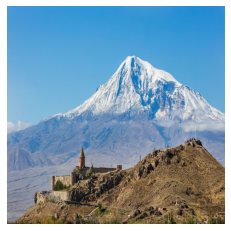

Image min/max is: 0.0/1.0. It should be 0.0/1.0


In [8]:
img_filename = os.path.join('data', 'mountain_3x.png')
img = plt.imread(img_filename)
print(f'Image size is {img.shape}')
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

print(f'Image min/max is: {img.min()}/{img.max()}. It should be 0.0/1.0')

### 3b. Load in pre-trained VGG16 network.

Like what you did on the Transfer Learning Task, load in the [pre-trained VGG16 network]((https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16)) and set it to a variable called `vgg`.

Don't load/include the trained output layer.

If you call the `summary()` method on the network object, you should see the following at the bottom:

    Total params: 14,714,688
    Trainable params: 14,714,688
    Non-trainable params: 0

In [9]:
vgg = tf.keras.applications.VGG16(include_top=False)
vgg.trainable = False
# vgg_adam = tf.optimizers.Adam(lr=1e-4)
# vgg.compile(optimizer=vgg_adam, loss='binary_crossentropy', metrics=['accuracy'])
vgg.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### 3c. Create a list of `VGG16` network layers whose activation we want to sample

Run the following code that define the layers and/or specific neurons whose activity we will amplify by adding their gradient back into the input image.

Then write code to create a Python list that stores the INDICES of **max pooling layers** from the big list of all network layer strings. The indices for the pooling layers should be `[3, 6, 10, 14, 18]`. Don't hard-code this because you will need to change the layer type later — come up with a robust, programatic approach to extracting the indices.

In [10]:
# Create a list of all NON-INPUT layer names in the VGG16 network.
# These are the strings in the left-most column in the `summary()` view above.
all_layer_names = [layer.name for layer in vgg.layers]

# Make a list of references to each layer's netAct values (`output` fields) of every NON-INPUT LEVEL layer object.
# Reference here is important bc we haven't showed the network the mountain image yet! But once we do,
# `layers` will point to the resulting activations.
layers = [vgg.get_layer(name).output for name in all_layer_names]

In [11]:
selectedLayerInds = []
for i in range(len(all_layer_names)):
    if "pool" in all_layer_names[i]:
         selectedLayerInds.append(i)
selectedLayerInds = np.array(selectedLayerInds)
selectedLayerNames = np.array(all_layer_names)[selectedLayerInds]

print('Max pooling layer names:\n', selectedLayerNames)
print('Max pooling layer indices:\n', selectedLayerInds)

Max pooling layer names:
 ['block1_pool' 'block2_pool' 'block3_pool' 'block4_pool' 'block5_pool']
Max pooling layer indices:
 [ 3  6 10 14 18]


### 3d. DeepDream iteration step 1: Compute the network activation to the input image


Below, you will pass the input image to the network to compute the forward pass activations (netAct) in each network layer.

#### Todo

- Make a new `tf.Variable` object from the numpy image data `img`. Recall, this is necessary to track its gradients throughout the network.
- Create a new `DeepDream` object, passing in all the necessary parameters for all the pooling layers in the network.
- Implement then test `forward` in `DeepDream`.

#### Test `forward`

1. Run `forward()` on the 1x mountain image with `filter_inds=[55, 56]`. If everything works, you should get the following mean netAct values from each respective the Max Pooling layer:<br/>`[2.79232359, 3.4536202, 1.45324695, 0.214050353, 0.716764152]`

2. Run `forward()` on the 1x mountain image with `filter_inds=[]`. If everything works, you should get the following mean netAct values from each respective the pooling layer:<br/>`[2.60964131, 4.14118624, 4.03892231, 0.559926212, 0.152407467]`


In [12]:
from deep_dream import *

In [13]:
# Make a keras 'Model' object that will allow us to pass in the input imagehttp://localhost:8888/notebooks/colby/CS343/project04/deep_dream.ipynb#Todo
# and get the activations (outputs) at each network level
tf_net = tf.keras.Model(inputs=layers[0], outputs=layers)


# Your code here
tf_img = tf.Variable(initial_value=img)

# Test 1
dream = DeepDream(net=tf_net, selected_layer_inds=list(selectedLayerInds), all_layer_names=list(all_layer_names), filter_inds=[55,56])
mean_netActs = dream.forward(tf_img)
print(f"mean netact values:\n {mean_netActs}")

# Test 2
dream = DeepDream(net=tf_net, selected_layer_inds=list(selectedLayerInds), all_layer_names=list(all_layer_names))
mean_netActs = dream.forward(tf_img)
print(f"mean netact values:\n {mean_netActs}")


mean netact values:
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.6815708>, <tf.Tensor: shape=(), dtype=float32, numpy=3.3921351>, <tf.Tensor: shape=(), dtype=float32, numpy=1.1811048>, <tf.Tensor: shape=(), dtype=float32, numpy=0.25377685>, <tf.Tensor: shape=(), dtype=float32, numpy=0.7447408>]
mean netact values:
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.5413387>, <tf.Tensor: shape=(), dtype=float32, numpy=3.7835274>, <tf.Tensor: shape=(), dtype=float32, numpy=3.4515996>, <tf.Tensor: shape=(), dtype=float32, numpy=0.36531997>, <tf.Tensor: shape=(), dtype=float32, numpy=0.12503287>]


**Note:** I was having trouble with type conversions, so this function outputs a list of tensors instead of floats.

### 3e. Questions

**Question 7:** Describe briefly in your own words the meaning of each of the single float values returned by `forward` (i.e. what does each number in the test code results represent)? You don't need to give 5 answers, just what does the $i^{th}$ one mean?

**Answer 7**: Each number is the average netact value at each layer either across every filter being used by the net or the selected filters specified in the init function. This average value represents how much the neurons reacted to the image on this layer, and we want to maximize it for deep dream.

### 3f. DeepDream iteration step 2: Compute normalized gradients of each layer with respect to input image

Here you will compute the gradient of each selected layer with respect to the input image. Use the gradient tape so that TensorFlow automatically will manage the gradients as you perform a forward pass on the image. Collect these recorded gradients and normalize them.

#### Todo

Implement `image_gradient` in `deep_dream.py`.

The gradients should be standardized: $$\hat{g} = \frac{g - \mu}{ \sigma +\epsilon}$$ where

- $g$ is the current gradient tensor
- $\mu$ is the mean of the layer gradient (computed over all units in the layer)
- $\sigma$ is the standard deviation of the layer gradient (computed over all units in the layer)
- $\epsilon$ is a small number to prevent division by 0 (e.g. `1e-8`) 

#### Test `image_gradient`

The below test code should result in the following for the 1x mountain image with all Max Pooling layers:

    [<tf.Tensor: shape=(), dtype=float32, numpy=-0.0015869141>,
     <tf.Tensor: shape=(), dtype=float32, numpy=-0.0006713867>,
     <tf.Tensor: shape=(), dtype=float32, numpy=0.00033569336>,
     <tf.Tensor: shape=(), dtype=float32, numpy=0.00021362305>,
     <tf.Tensor: shape=(), dtype=float32, numpy=-0.0014877319>]

In [14]:
img_grads = dream.image_gradient(tf_img, verbose=False)
[tf.reduce_sum(grad) for grad in img_grads]

[<tf.Tensor: shape=(), dtype=float32, numpy=-0.00390625>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.011474609>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.0053710938>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.0064697266>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.00995636>]

### 3g. Iterate DeepDream for multiple iterations: The gradient ascent algorithm

Bring the `forward` and `image_gradient` step together to iteratively perform DeepDream on the image. The result is a surreal, trippy, dreamy effect that merges the neural and image representations.

#### Todo

Implement the following methods in `deep_dream.py`:

- `gradient_ascent`. The updating process follows the equation $$x_{t+1} = x_t + \Delta_i \times s$$ where $x$ is the image tensor (*there is a t subscript because the image is changing as the neural signals affect it over time*), $\Delta_i$ is the gradient for the $i^{th}$ selected network layer, and $s$ is the step size.
- `tf2array`. We need this to visualize the results of DeepDream!

#### Test `gradient_ascent`

In the cell below, write code to test DeepDream/`gradient_ascent`. Overall, the test code that you write should resemble what you wrote in Task 3d. It should do the following:
- Wrap the mountain image as a `tf.Variable` type.
- Create a new `DeepDream` object and configure it so that only the last max pooling layer can affect the input image.
- Run gradient ascent on the image for 20 iterations.


It may be helpful to print (if verbose) the current iteration of gradient ascent to get a sense of progress.

#### Visualize the DeepDream image using `tf2array`

Now that you have your DeepDream image created through gradient ascent, call `tf2array` to convert it into an image that can visualized with matplotlib. Do this with `plt.imshow`.

[18]
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29


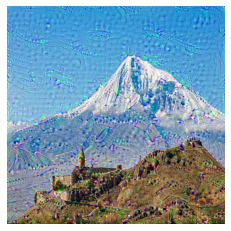

In [15]:
tf_net = tf.keras.Model(inputs=layers[0], outputs=layers)

tf_img = tf.Variable(initial_value=img)

dream = DeepDream(net=tf_net, selected_layer_inds=[list(selectedLayerInds)[-1]], all_layer_names=list(all_layer_names))

print(dream.selected_layer_inds)

tf_trippy = dream.gradient_ascent(tf_img, n_iter=30, verbose=True)

tf_trippy_np = dream.tf2array(tf_trippy)

plt.imshow(tf_trippy_np)
plt.xticks([])
plt.yticks([])
plt.savefig("mountain_dream.png", bbox_inches="tight")
plt.show()


### 3h. Refine DeepDream by running it with multiple image scales

While the existing algorithm results in some cool effects, some small additional work can make the DeepDream images look a lot better.

Implement `gradient_ascent_multiscale` in `deep_dream.py`. In this version, apply the gradient ascent algorithm on the image over multiple runs. Each time you finish a run, scale (enlarge) the image so that you run gradient ascent again on the larger version of image.

Since this is effectively repeating `gradient_ascent` a set number of times, it will take longer to finish computing. If `verbose` is turned on, add print outs showing "run-level" progress.

#### Test `gradient_ascent_multiscale`

Copy-and-paste your test code that you wrote for Task 3g, but now run `gradient_ascent_multiscale` instead of `gradient_ascent`. Run it with default parameters for now. Apply `tf2array` and visualize the resulting image using matplotlib.

In [ ]:
tf_net_multi = tf.keras.Model(inputs=layers[0], outputs=layers)

tf_img_multi = tf.Variable(initial_value=img)

dream_multi = DeepDream(net=tf_net_multi, selected_layer_inds=[list(selectedLayerInds)[-1]], all_layer_names=list(all_layer_names))

tf_trippy_multi = dream_multi.gradient_ascent_multiscale(tf_img_multi, n_iter=20, n_scales=8, verbose=True)

tf_trippy_np_multi = dream_multi.tf2array(tf_trippy_multi)

print(dream_multi.selected_layer_inds)

plt.imshow(tf_trippy_np_multi)
plt.xticks([])
plt.yticks([])
plt.show()


Multiplicative iteration 1 / 8
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Image shape is (873, 873, 3)
Multiplicative iteration 2 / 8
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Image shape is (1134, 1134, 3)
Multiplicative iteration 3 / 8
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15


In [ ]:
print(np.all(tf_trippy == tf_trippy_multi))

In [ ]:
NEWselectedLayerInds = []
for i in range(len(all_layer_names)):
    if "pool" in all_layer_names[i]:
         NEWselectedLayerInds.append(i)
selectedLayerNames = np.array(all_layer_names)[np.array(NEWselectedLayerInds)]

print('Max pooling layer names:\n', selectedLayerNames)
print('Max pooling layer indices:\n', NEWselectedLayerInds)

### 3i. Questions

Generate several DeepDream images to accompany each of your written answers to the following questions. You can include them inline with your answers below.

**Question 8:** Give at least two reasons why the multi-scale version tends to produce better visualizations. Hint: think about the filter receptive fields involved in the process.

**Question 9**: What differences do you notice if you only use earlier/later network layers to do the deep dream process?

**Question 10**: Describe what you notice when you let all max pooling layers contribute to the deep dream image.

**Question 11**: What happens when you pick specific filters to project rather than average all unit activation in a layer?

**Question 12**: Do you notice any difference when selecting a different layer type to do the Deep Dream process (other than max pooling)?

**Answer 8:** 1) More space allows for the net to make more detailed, higher resolution patterns in the image. 2) The filter receptive fields that give a high net act value for simple patterns like edges and lines are more likely to have a greater effect on the image when it has a smaller resolution and those that have high net act values for more complex patterns are more likely to have a greater effect when the image is larger. Variable resolution allows for both to have an effect on the final image.

In [ ]:
#Only using earlier network layers
tf_net_9_1 = tf.keras.Model(inputs=layers[0], outputs=layers)
tf_img_9_1 = tf.Variable(initial_value=img)
dream_9_1 = DeepDream(net=tf_net_9_1, selected_layer_inds=NEWselectedLayerInds[:2], all_layer_names=list(all_layer_names))
print(dream_9_1.selected_layer_inds)

tf_trippy_9_1 = dream_9_1.gradient_ascent_multiscale(tf_img_9_1, n_iter=20, verbose=False)

tf_trippy_np_9_1 = dream_9_1.tf2array(tf_trippy_9_1)


plt.imshow(tf_trippy_np_9_1)
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
#Only using later network layers
tf_net_9_2 = tf.keras.Model(inputs=layers[0], outputs=layers)
tf_img_9_2 = tf.Variable(initial_value=img)
dream_9_2 = DeepDream(net=tf_net_9_2, selected_layer_inds=NEWselectedLayerInds[-2:], all_layer_names=list(all_layer_names))
print(dream_9_2.selected_layer_inds)

tf_trippy_9_2 = dream_9_2.gradient_ascent_multiscale(tf_img_9_2, n_iter=20, verbose=False)

tf_trippy_np_9_2 = dream_9_2.tf2array(tf_trippy_9_2)


plt.imshow(tf_trippy_np_9_2)
plt.xticks([])
plt.yticks([])
plt.show()

**Answer 9**: It looks like using the earlier 2 layers brings out very small patterns while using higher level layers, like the last two in the list, bring out larger patterns in the image. This makes sense, as the kernels in low level layers will be much simpler, like edges and corners, but as the net pools the image, patterns in larger parts of the image appear because the kernels are looking across larger sections of the image.

In [ ]:
#Using all max pool layers
tf_net_10 = tf.keras.Model(inputs=layers[0], outputs=layers)
tf_img_10 = tf.Variable(initial_value=img)
dream_10 = DeepDream(net=tf_net_10, selected_layer_inds=NEWselectedLayerInds, all_layer_names=list(all_layer_names))
print(dream_10.selected_layer_inds)
tf_trippy_10 = dream_10.gradient_ascent_multiscale(tf_img_10, n_iter=10, verbose=False)

tf_trippy_np_10 = dream_10.tf2array(tf_trippy_10)


plt.imshow(tf_trippy_np_10)
plt.xticks([])
plt.yticks([])
plt.show()

**Answer 10**: Using every max pooling layer results, not too surprisingly, in kind of a combination between 9_1 and 9_2. We see larger patterns emerging, but these are kind of made up of smaller patterns in a fractal-esque way.

In [ ]:
#using specific filters instead of every one
tf_net_11 = tf.keras.Model(inputs=layers[0], outputs=layers)
tf_img_11 = tf.Variable(initial_value=img)
dream_11 = DeepDream(net=tf_net_11, selected_layer_inds=NEWselectedLayerInds, all_layer_names=list(all_layer_names), filter_inds=[35,60])
print(dream_11.selected_layer_inds)
tf_trippy_11 = dream_11_1.gradient_ascent_multiscale(tf_img_11, n_iter=10, verbose=False)

tf_trippy_np_11 = dream_11_1.tf2array(tf_trippy_11)


plt.imshow(tf_trippy_np_11)
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
#using specific filters instead of every one
tf_net_11_1 = tf.keras.Model(inputs=layers[0], outputs=layers)
tf_img_11_1 = tf.Variable(initial_value=img)
dream_11_1 = DeepDream(net=tf_net_11_1, selected_layer_inds=NEWselectedLayerInds, all_layer_names=list(all_layer_names), filter_inds=[22,53])
print(dream_11_1.selected_layer_inds)
tf_trippy_11_1 = dream_11_1.gradient_ascent_multiscale(tf_img_11_1, n_iter=10, verbose=False)

tf_trippy_np_11_1 = dream_11_1.tf2array(tf_trippy_11_1)


plt.imshow(tf_trippy_np_11)
plt.xticks([])
plt.yticks([])
plt.show()

**Answer 11**: From the two examples of randomly choosing values here, it seems as though specific patterns and colors are repeated, compared to the more homogenous result of averaging all of the filters in the layer.

In [ ]:
#using different layers than max pools
conv_selectedLayerInds = []
for i in range(len(all_layer_names)):
    if "conv3" in all_layer_names[i]:
         conv_selectedLayerInds.append(i)

conv_selectedLayerNames = np.array(all_layer_names)[np.array(conv_selectedLayerInds)]

print('Conv 3 layer names:\n', conv_selectedLayerNames)
print('Conv 3 layer indices:\n', conv_selectedLayerInds)

In [ ]:
tf_net_12 = tf.keras.Model(inputs=layers[0], outputs=layers)
tf_img_12 = tf.Variable(initial_value=img)
dream_12 = DeepDream(net=tf_net_12, selected_layer_inds=conv_selectedLayerInds, all_layer_names=list(all_layer_names))
print(dream_12.selected_layer_inds)
tf_trippy_12 = dream_12.gradient_ascent_multiscale(tf_img_12, n_iter=10, verbose=True)

tf_trippy_np_12 = dream_12.tf2array(tf_trippy_12)


plt.imshow(tf_trippy_np_12)
plt.xticks([])
plt.yticks([])
plt.show()

**Answer 12**: Choosing convolution layer (above) results in a pretty similar image, perhaps with more distortion.

## Extensions

### 1. Run Deep Dream on your own images. Make some interesting effects.

Note that you will likely have to convert images from uint8 to float32 and normalize to the [0, 1] range.

You will probably want to resize your images as part of the preprocessing to keep simulation time reasonable.

Play with the number of gradient ascent iterations.

In [ ]:
# get pre-trained VGG network
vgg_monet = tf.keras.applications.VGG19(include_top=False)
vgg_monet.trainable = False

# get layers of VGG network
all_monet_layer_names = [layer.name for layer in vgg_monet.layers]
all_monet_layers = [vgg_monet.get_layer(name).output for name in all_monet_layer_names]

select_monet_layer_inds = []
for i in range(len(all_monet_layer_names)):
    if "pool" in all_monet_layer_names[i]:
         select_monet_layer_inds.append(i)
select_monet_layer_inds = np.array(select_monet_layer_inds)
select_monet_layer_names = np.array(all_monet_layer_names)[select_monet_layer_inds]

# forward pass
tf_monet_net = tf.keras.Model(inputs=all_monet_layers[0], outputs=all_monet_layers)
tf_monet_img = tf.Variable(initial_value=img_monet)

monet_dream_1 = DeepDream(net=tf_monet_net, selected_layer_inds=list(select_monet_layer_inds), all_layer_names=list(all_monet_layer_names), filter_inds=[])
monet_mean_net_acts = monet_dream_1.forward(tf_monet_img)

# normalized gradients
monet_img_grads = monet_dream_1.image_gradient(tf_monet_img, verbose=False)
[tf.reduce_sum(grad) for grad in monet_img_grads]

# visualize deep dream water lillies image with gradient ascent multiscale
new_tf_monet_net = tf.keras.Model(inputs=all_monet_layers[0], outputs=all_monet_layers)
new_tf_monet_img = tf.Variable(initial_value=img_monet)

monet_dream_2 = DeepDream(net=new_tf_monet_net, selected_layer_inds=[list(select_monet_layer_inds)[-1]], all_layer_names=list(all_monet_layer_names))
monet_trippy = monet_dream_2.gradient_ascent_multiscale(new_tf_monet_img, n_iter=15, n_scales=3, verbose=True)
monet_trippy_np = monet_dream_2.tf2array(monet_trippy)

plt.imshow(monet_trippy_np)
plt.xticks([])
plt.yticks([])
plt.show()

### 2. Research other pretrained networks in tensorflow and run DeepDream on their layers/filters.

### 3. Automate the visualization process for many filters and/or subsets of layers. Make grids of output images. Do you find patterns in any of the filters?

### 4. Transfer learning: What's the best test accuracy that you can achieve on the hot dog or not dataset? How did you do it?

### 5. Keras ConvNet4: Explore and analyze how different network architectures affect the STL-10 results.

### 6. Transfer learning: Can you apply Transfer learning to a binary or multi-class classification task with another dataset of your choice?